## packages and functions

In [1]:
import numpy as np
import sys
import matplotlib.pyplot as plt
import xarray as xr
import h5py
from scipy.io import loadmat
import matplotlib as mpl
import time
import gsw
from matplotlib.colors import TwoSlopeNorm

# import existing python files
plt.rcParams['figure.figsize'] = (10,4)

# add rdmds reading functions to path
sys.path.append("/home/mmurakami/MITgcm/MITgcm_c68r/MITgcm-checkpoint68r/utils/python/MITgcmutils/MITgcmutils/") # go to parent dir
from mds import *

# add the other files
sys.path.append("/home/mmurakami/crios_backups/an_helper_functions")
from read_binary import *
from calc_UV_conv_1face import calc_UV_conv_1face
from calc_mskmean_T_mod import calc_mskmean_T_mod
from mk3D_mod import mk3D_mod
from aste_helper_funcs import *
from timing_functions import *           # ts2dte, get_fnames, etc.
from binning import *                    # bin_array, create_mesh

### Read grid and masks

In [2]:
# define basin we want
iB = 6   # see mskBasin if you want for later; maybe we should write this to file

In [3]:
dirroot = "/scratch2/atnguyen/aste_270x450x180/"
dirrun = "/scratch/atnguyen/aste_270x450x180/OFFICIAL_ASTE_R1_Sep2019/"
dirIn = dirrun + "diags/BUDG/"
dirDiags = dirrun + "diags/"
dirState = dirDiags + "STATE/"
dirGrid = dirroot + "GRID_real8/"
dirgridnb = dirroot + "GRID_noblank/"
dirgridw = dirroot + "GRID_wet/"

In [4]:
bigaste = True

if bigaste:
    nx = 270
    ncut1 = 450
    ncut2 = 180
else:
    nx = 90
    ncut1 = 150
    ncut2 = 60
    
ny = 2*ncut1+nx+ncut2
nz = 50
nfx = np.array([nx, 0 , nx, ncut2 ,ncut1])
nfy = np.array([ncut1, 0 , nx, nx, nx])

In [5]:
# save myParms from An hard-coding
save_budg_3d = 0
save_budg_2d = 1
save_budg_scalar = 0
save_budg_lev = 0

strbudg = 'Mass'
kBudget = 1
test3d = True
plot_fig = 1
# kz = [[1, 5], [6, 10], [11, 19], [20, 23]]

myparms = {
    'yearFirst': 1979,
    'yearLast': 1979,
    'yearInAv': [1979, 1979],
    'timeStep': 3600,
    'iceModel': 1,
    'useRFWF': 1,
    'useNLFS': 4,
    'rStar': 2,
    'rhoconst': 1029,
    'rcp': 1029 * 3994,    # reference seawater specific heat capacity (1029 kg/m^3) * (3994 J/kg K) = J/(m^3*degC)
    'rhoi': 910,
    'rhosn': 330,
    'flami': 334000,
    'flamb': 2500000,
    'SIsal0': 4,
    'diagsAreMonthly': 0,
    'diagsAreAnnual': 0,
    'recInAve': [1, 2],
    'SaltPlumeHeatFlux': 0,  # Not sure what this is
    'conserveTr': 0
}

deltaTime = myparms['timeStep']
dt = 86400

In [6]:
# get time-steps:
flist = [f for f in os.listdir(dirIn) if f.startswith('budg2d_snap_set1.') and f.endswith('.data')]
idot = flist[0].index('.')
idot = [idot+1, flist[0][idot+1:].index('.')+idot+1]
idot = np.asarray(idot,dtype=int)

mygrid = {
    'dirGrid': dirGrid,
    'nFaces': 1,
    'fileFormat': 'compact',
    'memoryLimit': 2,
    'ioSize': [nx*ny, 1],
    'facesSize': [ny, nx],
    'facesExpand': [ny, nx],
    'missVal': 0,
}

fldstr2d = ['XC','YC','XG','YG','RAC','Depth','DXG','DYG','DXC','DYC']
fldstr3d = ['hFacC','hFacW','hFacS','mskC','mskS','mskW']
fldstr3dp = ['hFacC','hFacW','hFacS','maskCtrlC','maskCtrlS','maskCtrlW']
fldstr1d = ['RC','RF','DRC','DRF']

for fld in fldstr1d:
    mygrid[fld] = np.squeeze(rdmds(os.path.join(dirGrid, fld)))

for fld in fldstr3d:
    temp = rdmds(os.path.join(dirGrid, fldstr3dp[fldstr3d.index(fld)]))
    mygrid[fld] = temp.reshape(nz, ny, nx)

for fld in fldstr2d:
    temp = rdmds(os.path.join(dirGrid, fld))
    mygrid[fld] = temp.reshape(ny, nx)

mygrid['mskC'][mygrid['mskC'] == 0] = np.nan

areaW, areaS, Vol = [], [], []
for k in range(nz):
    areaW.append(mygrid['DYG'] * mygrid['DRF'][k])
    areaS.append(mygrid['DXG'] * mygrid['DRF'][k])
    Vol.append(mygrid['RAC'] * mygrid['DRF'][k])

In [7]:
# block out obcs
# np tile I think operates the same as repmat in MATLAB
RAC = mygrid['RAC']
RAC3 = np.tile(RAC,(nz,1,1))

hfC = mygrid['hFacC']
DD = mygrid['Depth']
dxg = mygrid['DXG']
dyg = mygrid['DYG']
dxg3d = np.tile(dxg,(nz,1,1))
dyg3d = np.tile(dyg,(nz,1,1))

print(mygrid['DRF'].shape,np.zeros((nz, ny, nx)).shape)
drf3d = mk3D_mod(mygrid['DRF'], np.zeros((nz, ny, nx)))
DD3d = mk3D_mod(DD,np.zeros((nz, ny, nx)))

hfC[hfC == 0] = np.nan
hfC1 = hfC[0, :, :]
hfC1[hfC1 == 0] = np.nan

RACg = RAC * hfC1
hfC1p = np.copy(hfC1)

hfC1p[:, nx-1] = np.nan
hfC1p[ny-1,:] = np.nan
RACgp = RAC * hfC1p

(50,) (50, 1350, 270)


In [8]:
#mygrid['hFacC'][mygrid['hFacC'] > 0] = 1
mygrid['hFacC'][mygrid['hFacC'] == 0] = np.nan
hf1 = mygrid['hFacC'][0] # top layer in z

print("hf1",hf1.shape)

hf1 = get_aste_tracer(hf1, nfx, nfy)
# check with hardcoding on this for mini or big aste
if nx == 90:
    hf1[:,281,:] = np.nan
    hf1[:,7,:] = np.nan
    hf1[:,86,122] = np.nan
elif nx == 270:
    hf1[:,844,:] = np.nan
    hf1[:,23,:] = np.nan
    hf1[:,365,260:261] = np.nan

hf1 = aste_tracer2compact(hf1,nfx,nfy)
hf = mygrid["hFacC"]
hf = hf * np.tile(hf1,(nz, 1,1))

hf1 (1350, 270)


In [9]:
# copy basin listing from lookat_layers
fileprefix = "/scratch/pillarh/aste_270x450x180/"
extBasin='run_template/input_maskTransport/'
filename = fileprefix + extBasin + "GATE_transports_v3_osnap.mat"
if nx == 270:
    inf = loadmat(filename)
    mskBasin = (inf["mskBasin"])

mskBasin = mskBasin.T               # python adjustment

# this is now different syntax than the other file
strb=np.array(['CanadaB','ChukchiS','MakarovB','AmundsenB','NansenB','BeringS','BarentsS','GINs','CAA',
               'SPG','LabSea','NPac','NAtlantic','AtlS30'])

mskBasin[mskBasin==50] =6
mskBasin[mskBasin==200]=7
mskBasin[mskBasin==300]=8
mskBasin[mskBasin==400]=9
mskBasin[mskBasin==500]=9
mskBasin[mskBasin==600]=10
mskBasin[mskBasin==700]=11
mskBasin[mskBasin==-1]=12
mskBasin[mskBasin==-100]=13
latNA = 30
lonNA = -82
condition_13 = (mskBasin == 0) & (mygrid['YC'] > latNA) & (mygrid['XC'] > lonNA) & (hf1.reshape((ny,nx)) > 0)
mskBasin[condition_13] = 13
condition_14 = (mskBasin == 0) & (hf1.reshape((ny,nx)) > 0)
mskBasin[condition_14] = 14

mskBasin = mskBasin * hf1
mskBasin = mskBasin[0,:,:]   # change indexing for  python
mskBasin -= 1

# create mskBasin3D to also add to the dataset
mskBasin3D = np.tile(mskBasin[np.newaxis,:,:],(nz,1,1))
mskBasin3D.shape

(50, 1350, 270)

### Get timesteps

In [19]:
# create an array of the time steps we want to read
# use ts2dte to get december 2014
# first make an array of filenames
dt = 600
startyr = 2002
endyr = 2019

# all the filenames in the system
fnames = get_fnames(dt,startyr,endyr)

times = {}
# times["2014"] = np.arange(3,5,1)
times["2002"] = np.arange(2,4,1)

# the filenames we want for 2014
tsstr,datetimes = get_tsteps(times,fnames,dt,startyr,1,1)

t2 = int(tsstr[1])

### mass tendency

In [11]:
# ocean and ice
AB_gT=0
AB_gS=0
debug = False

In [12]:
# ffac = 1e-6
ffac = 1

In [13]:
dt = datetimes[1]-datetimes[0]   # days
dt = dt.total_seconds()

In [34]:
file_name = 'budg2d_snap_set1'
meta_budg2d_snap_set1 = parsemeta(dirIn + file_name + "." + tsstr[0] + ".meta")

# try to read this with rec
fldlist = np.array(meta_budg2d_snap_set1['fldList'])
varnames = np.array(['ETAN','PHIBOT','SIheff','SIhsnow'])
recs = np.array([])
for var in varnames:
    irec = np.where(fldlist == var)
    recs = np.append(recs, irec[0][0])

ETAN = np.full((len(tsstr),ny,nx),np.nan)
PHIBOT = np.full((len(tsstr),ny,nx),np.nan)
SIheff = np.full((len(tsstr),ny,nx),np.nan)
SIhsnow = np.full((len(tsstr),ny,nx),np.nan)

for i in range(len(tsstr)):
    thisETAN,its,meta = rdmds(os.path.join(dirIn, file_name),int(tsstr[i]),returnmeta=True,rec=recs[0])
    thisETAN = thisETAN.reshape(ny,nx)
    ETAN[i] = thisETAN

    thisPHIBOT,its,meta = rdmds(os.path.join(dirIn, file_name),int(tsstr[i]),returnmeta=True,rec=recs[1])
    thisPHIBOT = thisPHIBOT.reshape(ny,nx)
    PHIBOT[i] = thisPHIBOT

    thisSIheff,its,meta = rdmds(os.path.join(dirIn, file_name),int(tsstr[i]),returnmeta=True,rec=recs[2])
    thisSIheff = thisSIheff.reshape(ny,nx)
    SIheff[i] = thisSIheff

    thisSIhsnow,its,meta = rdmds(os.path.join(dirIn, file_name),int(tsstr[i]),returnmeta=True,rec=recs[3])
    thisSIhsnow = thisSIhsnow.reshape(ny,nx)
    SIhsnow[i] = thisSIhsnow

ETAN =  (ETAN[1, :, :] - ETAN[0, :, :]) / dt
PHIBOT = (PHIBOT[1, :, :] - PHIBOT[0, :, :]) / dt
SIheff =  (SIheff[1, :, :] - SIheff[0, :, :]) / dt
SIhsnow = (SIhsnow[1, :, :] - SIhsnow[0, :, :]) / dt

In [35]:
# 3D, with rStar:
# mk3D_mod function should be called here but I might be doing it wrong
tmptend = np.zeros((nz, ny, nx))
if myparms['useNLFS'] < 2 or myparms['rStar'] == 0:        # not this time
    tmptend[0,:, :] = ETAN * myparms['rhoconst'] * RAC
    if myparms['useRFWF'] == 0:
        tmptend[0, :, :] = np.zeros((ny, nx))
else:
    if myparms['useRFWF'] != 0:                                 # we are using this  # check if tmp1 is the same as drf3d!!
        tmp1 = mk3D_mod(mygrid['DRF'],hfC) * hfC
        tmp2 = tmp1/mk3D_mod(DD,tmp1)
    else:
        tmp2 = drf3d / mk3D_mod(DD, tmp1)
        
    tmptend = tmp2 * np.tile(ETAN[np.newaxis,:,:],(nz,1,1)) * RAC3

In [36]:
budgO = {}
budgO = {'fluxes': {'tend': tmptend}}
budgO['tend'] = np.nansum(tmptend,axis=0)
budgI = {'tend': (SIheff * myparms['rhoi'] + SIhsnow * myparms['rhosn'] * RAC)}

In [37]:
# budgI = {'tend': (SIheff * myparms['rhoi'] + SIhsnow * myparms['rhosn']) * RAC}
budgOI = {}
budgOI['tend'] = budgO['tend'] + budgI['tend']

### Calculate horizontal convergence
We used to do this with calc_UV_conv_1face but now we just want totally the calc_UV

In [38]:
# read U and V mass
meta_budg3d_hflux_set2= parsemeta(dirIn + "budg3d_hflux_set2" + '.' + tsstr[1] + '.meta')
fldlist = np.array(meta_budg3d_hflux_set2['fldList'])
varnames = np.array(['UVELMASS','VVELMASS'])
recs = np.array([])
for var in varnames:
    irec = np.where(fldlist == var)
    recs = np.append(recs, irec[0][0])
UVELMASS,its,meta = rdmds(dirIn + "budg3d_hflux_set2", int(tsstr[1]),returnmeta=True,rec = recs[0])       # m/s
VVELMASS,its,meta = rdmds(dirIn + "budg3d_hflux_set2", int(tsstr[1]),returnmeta=True,rec = recs[1])       # m/s

# read advective
meta_budg2d_hflux_set1= parsemeta(dirIn + "budg2d_hflux_set1" + '.' + tsstr[1] + '.meta')
fldlist = np.array(meta_budg2d_hflux_set1['fldList'])
varnames = np.array(['ADVxHEFF','ADVyHEFF','ADVxSNOW','ADVySNOW'])
recs = np.array([])
for var in varnames:
    irec = np.where(fldlist == var)
    recs = np.append(recs, irec[0][0])
ADVxHEFF,its,meta = rdmds(dirIn + "budg2d_hflux_set1", int(tsstr[1]),returnmeta=True,rec = recs[0])       # m.m^2/s    ice 
ADVyHEFF,its,meta = rdmds(dirIn + "budg2d_hflux_set1", int(tsstr[1]),returnmeta=True,rec = recs[1])       # m.m^2/s    ice 
ADVxSNOW,its,meta = rdmds(dirIn + "budg2d_hflux_set1", int(tsstr[1]),returnmeta=True,rec = recs[2])       # m.m^2/s    snow
ADVySNOW,its,meta = rdmds(dirIn + "budg2d_hflux_set1", int(tsstr[1]),returnmeta=True,rec = recs[3])

In [39]:
UVELMASS = UVELMASS.reshape(nz,ny,nx)
VVELMASS = VVELMASS.reshape(nz,ny,nx)
ADVxHEFF = ADVxHEFF.reshape(ny,nx)
ADVyHEFF = ADVyHEFF.reshape(ny,nx)
ADVxSNOW = ADVxSNOW.reshape(ny,nx)
ADVySNOW = ADVySNOW.reshape(ny,nx)

In [40]:
# THERE IS NO DFXEHEFF OR DFYEHEFF! This has not been handled in this notebook
# Calculations for ocean
tmpUo = myparms['rhoconst'] * dyg3d * drf3d * UVELMASS    # m/s * m * m * kg/m^3 = kg/s
tmpVo = myparms['rhoconst'] * dxg3d * drf3d * VVELMASS    # kg/s

# replace tmpUo and tmpVo with the faces here
tmpUo = get_aste_faces(tmpUo,nfx,nfy)              
tmpVo = get_aste_faces(tmpVo,nfx,nfy)

# tmpUo,tmpVo = get_aste_vector_face1_3(tmpUo,tmpVo,nfx,nfy,False)
conv = calc_UV_conv_mod(nfx,nfy,tmpUo,tmpVo) #[:,:-1,:-1]

In [41]:
budgO['fluxes']['hconv'] = conv
budgO['hconv'] = calc_UV_conv_mod(nfx,nfy,np.nansum(tmpUo, axis=0), np.nansum(tmpVo, axis=0))

In [42]:
# plt.pcolormesh(get_aste_tracer(budgO['fluxes']['hconv'][5],nfx,nfy)[0],cmap='seismic',vmin=-1e7,vmax=1e7)
# plt.colorbar()
# plt.xlim(400,540)
# plt.ylim(440,460)

### Calculate vertical convergence

In [43]:
# rewrite with only reading in these lines, be sure to compare
meta_budg2d_zflux_set1= parsemeta(dirIn + "budg2d_zflux_set1" + '.' + tsstr[1] + '.meta')
fldlist = np.array(meta_budg2d_zflux_set1['fldList'])
varnames = np.array(['oceFWflx','SIatmFW'])
recs = np.array([])
for var in varnames:
    irec = np.where(fldlist == var)
    recs = np.append(recs, irec[0][0])
# net surface Fresh-Water flux into the ocean (+=down), >0 decreases salinity
oceFWflx,its,meta = rdmds(dirIn + "budg2d_zflux_set1", int(tsstr[1]),returnmeta=True,rec = recs[0])
# Net freshwater flux from atmosphere & land (+=down)
SIatmFW,its,meta = rdmds(dirIn + "budg2d_zflux_set1", int(tsstr[1]),returnmeta=True,rec = recs[1])

oceFWflx = oceFWflx.reshape(ny,nx)                     # kg/m^2/s
SIatmFW = SIatmFW.reshape(ny,nx)                       # kg/m^2/s


# read WVELMASS
meta_budg3d_zflux_set2= parsemeta(dirIn + "budg3d_zflux_set2" + '.' + tsstr[1] + '.meta')
fldlist = np.array(meta_budg3d_zflux_set2['fldList'])
varnames = np.array(['WVELMASS'])
recs = np.array([])
for var in varnames:
    irec = np.where(fldlist == var)
    recs = np.append(recs, irec[0][0])
# Vertical Mass-Weighted Comp of Velocity
WVELMASS,its,meta = rdmds(dirIn + "budg3d_zflux_set2", int(tsstr[1]),returnmeta=True,rec = recs[0])
WVELMASS = WVELMASS.reshape(nz,ny,nx)

In [44]:
# Perform calculations
budgO["zconv"] = oceFWflx
budgI["zconv"] = SIatmFW - oceFWflx

if not myparms["useRFWF"]:
    budgO["zconv"] = 0 * budgO["zconv"]

trWtop = -WVELMASS * myparms["rhoconst"]
print(trWtop.shape)

if myparms["useNLFS"] < 2 or myparms["rStar"] == 0:
    trWtop[0, :, :] = oceFWflx
    if not myparms["useRFWF"]:
        trWtop[0,:, :] = -WVELMASS[0,:, :] * myparms["rhoconst"]

# same size trWtop and TrWbot
trWbot = np.zeros_like(trWtop)
trWbot[:-1,:, :] = trWtop[1:,:, :]

#budgO["fluxes"] = {}
budgO["fluxes"]["trWtop"] = trWtop * RAC3
budgO["fluxes"]["trWbot"] = trWbot * RAC3
budgO["fluxes"]["zconv"] = budgO["fluxes"]["trWtop"] - budgO["fluxes"]["trWbot"]

# changed axis here to 0 because we're looking at z
if myparms["useNLFS"] < 2 or (myparms["rStar"] == 0 and not myparms["useRFWF"]):
    budgO["zconv"] += np.sum(trWtop - trWbot, axis=0)

# budgI["fluxes"] = {}
# budgI["fluxes"]["trWtop"] = -RAC * (budgI["zconv"] + budgO["zconv"])
# budgI["fluxes"]["trWbot"] = -RAC * budgO["zconv"]

budgO["zconv"] = RAC * budgO["zconv"]
# budgI["zconv"] = RAC * budgI["zconv"]
# budgOI["zconv"] = budgO["zconv"] + budgI["zconv"]

(50, 1350, 270)


### Is this budgeted in horizontal space?

In [45]:
# pick one point from face 3 and one point from face 1
pt = np.array([[25,500,4],       # this is organized as x,y,z
               [220,445,10]])

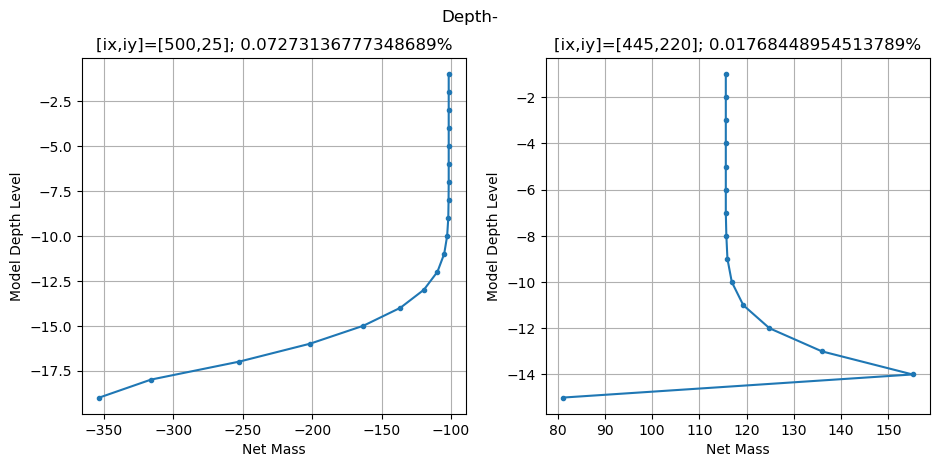

In [46]:
# Figure 1
plt.figure(1, figsize=(9.5, 8.5))
aa = np.zeros((nz, 4))
plt.suptitle("Depth-")

# four figures labeled n
for n in range(1, 3):
    ix, iy, k = pt[n-1]
    aa[:, n-1] = budgO['fluxes']['tend'][:, iy, ix] - budgO['fluxes']['zconv'][:, iy, ix] - budgO['fluxes']['hconv'][:, iy, ix]
    #aa[:, n-1] = budgO['tend'][iy, ix] - budgO['hconv'][0,iy, ix] - budgO['zconv'][iy, ix]

    plt.subplot(2, 2, n)
    plt.plot(aa[:, n-1], -np.arange(1, nz+1), '.-')
    plt.grid()
    #plt.xlabel(f"net budg{strbudg[0]}o")
    plt.xlabel("Net Mass")
    plt.ylabel("Model Depth Level")
    plt.title(f"[ix,iy]=[{iy},{ix}]; {100 * np.nanmax(np.abs(aa[:, n-1]))/np.nanmax(np.abs(budgO['fluxes']['zconv'][:,iy, ix]))}%")
        
plt.tight_layout()
plt.show()

In [30]:
a = budgO['fluxes']['tend'] * np.tile(hfC1p[np.newaxis,:, :], (nz, 1, 1))
b = budgO['fluxes']['hconv'] * np.tile(hfC1p[np.newaxis,:, :], (nz, 1, 1))
c = budgO['fluxes']['zconv'] * np.tile(hfC1p[np.newaxis,:, :], (nz, 1, 1))

a[np.isnan(a)] = 0
b[np.isnan(b)] = 0
c[np.isnan(c)] = 0

In [ ]:
# Figure 2


klev = [1, 2, 15]
fig, axes = plt.subplots(3, 4, figsize=(14, 9))

for idx, k1 in enumerate(klev):
    str_k = f"; k={k1}"
    fourth = 1
    for j, (data, title) in enumerate([(a, 'tend'), (b, 'hconv'), (c, 'zconv'), (a-b-c, 'tend-hconv-zconv')]):
        ax = axes[idx, j]
        mydata = get_aste_tracer(data[k1-1,:, :],nfx,nfy)[0]
        #mydata = data[k1-1,:, :]
        if fourth == 4:
            pcm = ax.pcolormesh(mydata, cmap='seismic', vmin=-1e-6, vmax=1e-6)
        else:
            pcm = ax.pcolormesh(mydata, cmap='seismic', vmin=-0.99*abs(data[k1-1,:, :].max()), vmax=0.99*abs(data[k1-1,:, :].max()))
        fig.colorbar(pcm, ax=ax)

        #ax.scatter(get_aste_tracer(np.array([[533],[56]]),nfx,nfy)[0])
    
        ax.set_title(f"{strbudg} {title} {str_k}")
        ax.set_xlim(410,540)
        ax.set_ylim(420,610)

        fourth += 1

plt.tight_layout()
# plt.savefig(f"{dirOut}{strbudg}_budget2_{t2:010}.png")
plt.show()

# do a single point comparison to prove that this is budgeted

In [ ]:
UVELMASS[18,y,x]

In [ ]:
# do the surface, bottom and one other point
x = pt[0][0]
y = pt[0][1]
z = 18    # also do 5, 18 (or 17)

In [ ]:
# do the point breakdown
a = (budgO['fluxes']['tend'][z, y, x])
b = (budgO['fluxes']['zconv'][z, y, x])
c = (budgO['fluxes']['hconv'][z, y, x])
print(a-b-c)

# great, this is budgeted, now we can move on to heat and try to create the vectors